In [63]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [64]:
df = pd.read_csv("GlobalLandTemperaturesByState.csv")
df = df[['dt', 'AverageTemperature', 'State']]
df['dt'] = pd.to_datetime(df['dt']) # in order to filter out years below 2000
df = df[df['dt'].dt.year >= 2000]
df = df[df['State'].isin(["Wyoming", "Nebraska", "South Dakota"])]
df

,dt,AverageTemperature,State
350761,2000-01-01,-2.024,Nebraska
350762,2000-02-01,1.719,Nebraska
350763,2000-03-01,5.687,Nebraska
350764,2000-04-01,9.417,Nebraska
350765,2000-05-01,16.827,Nebraska
...,...,...,...
626435,2013-05-01,10.607,Wyoming
626436,2013-06-01,16.267,Wyoming
626437,2013-07-01,20.222,Wyoming
626438,2013-08-01,19.621,Wyoming


In [65]:
df.pop('State')
df['Decimal Date'] = (df['dt'].dt.year + (df['dt'].dt.month - 1) / 12 + (df['dt'].dt.day - 1) / 365.25)
df = df.groupby(['dt']).mean()
df

,AverageTemperature,Decimal Date
dt,,
2000-01-01,-4.072000,2000.000000
2000-02-01,-0.205000,2000.083333
2000-03-01,3.642667,2000.166667
2000-04-01,7.609667,2000.250000
2000-05-01,14.255000,2000.333333
...,...,...
2013-05-01,13.196000,2013.333333
2013-06-01,18.783667,2013.416667
2013-07-01,22.110333,2013.500000


Text(0.5, 1.0, 'Average temperature over time in Wyoming, Nebraska and South Dakota')

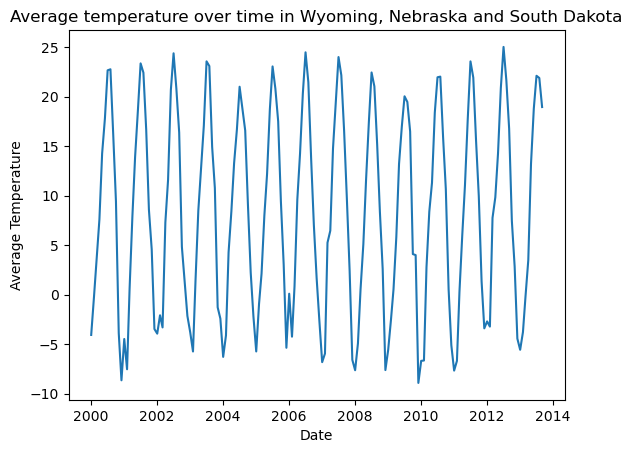

In [66]:
plt.figure()
plt.plot(df['AverageTemperature'])
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Average temperature over time in Wyoming, Nebraska and South Dakota')

In [70]:
def f(t, A, B, C, D):
    return A*np.cos(B*t + C) + D 

initial_guesses = np.array([25, 2*np.pi, 0, 10])

params, covariance = scipy.optimize.curve_fit(f, df['Decimal Date'], df['AverageTemperature'], initial_guesses)
params

array([-13.89959778,   6.2793724 ,   7.59271205,   8.12294993])

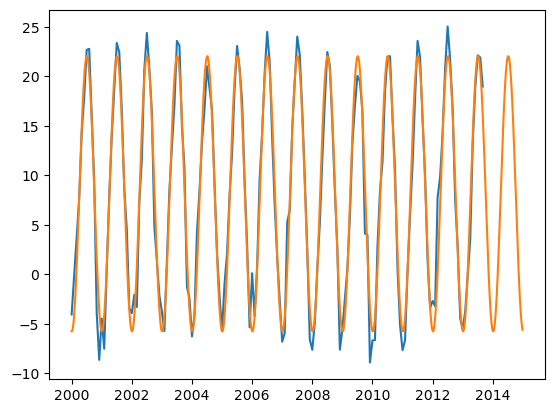

In [82]:
plt.figure()
plt.plot(df['Decimal Date'], df['AverageTemperature'])
x = np.arange(2000, 2015, 0.01)
y = f(x, -13.89959778, 6.2793724, 7.59271205, 8.12294993)
plt.plot(x, y)

In [96]:
print(f"A: {params[0]} +/- {np.sqrt(covariance[0,0])}")
print(f"B: {params[1]} +/- {np.sqrt(covariance[1,1])}")
print(f"C: {params[2]} +/- {np.sqrt(covariance[2,2])}")
print(f"D: {params[3]} +/- {np.sqrt(covariance[3,3])}")
print(f"Final equation: y = {params[0]} * cos({params[1]} * t + {params[2]}) + {params[3]}")

A: -13.899597775071898 +/- 0.22634526824909285
B: 6.279372404050181 +/- 0.004158616691620466
C: 7.5927120453449 +/- 8.345648260294995
D: 8.122949930661383 +/- 0.16050593249848985
Final equation: y = -13.899597775071898 * cos(6.279372404050181 * t + 7.5927120453449) + 8.122949930661383


In [109]:
from astropy.table import Table

table = Table.read('global_CCl4_MM.dat', format='ascii')  # or 'global_SF6_MM.dat'
data = table.to_pandas()
data['decimal year'] = data['CCl4ottoyr'] + (data['CCl4ottomon'] - 0.5) / 12
data = data[['decimal year', 'CCl4ottoGLm', 'CCl4ottoGLsd']]
data = data.drop([0,1,2,283,284,285,286,287])
data

,decimal year,CCl4ottoGLm,CCl4ottoGLsd
3,1996.291667,104.144,0.155
4,1996.375000,103.893,0.174
5,1996.458333,104.207,0.191
6,1996.541667,104.136,0.147
7,1996.625000,103.836,0.161
...,...,...,...
278,2019.208333,79.008,0.199
279,2019.291667,78.623,0.149
280,2019.375000,78.862,0.226
281,2019.458333,78.598,0.165


Text(0.5, 1.0, 'Global Mean Concentration Over Time')

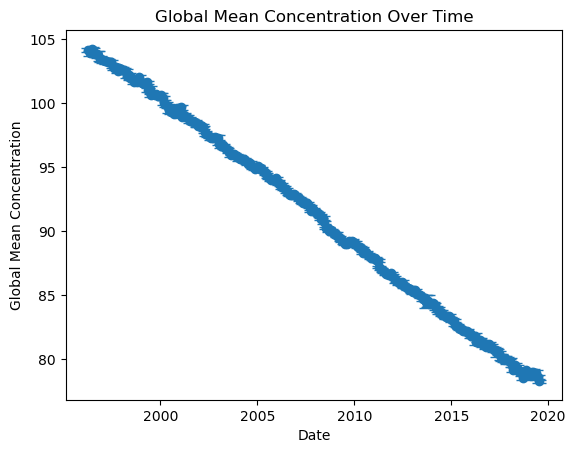

In [110]:
plt.figure()
plt.errorbar(data['decimal year'], data['CCl4ottoGLm'], yerr=data['CCl4ottoGLsd'], 
             fmt='o', capsize=5, label='Data with error bars')
plt.xlabel('Date')
plt.ylabel('Global Mean Concentration')
plt.title('Global Mean Concentration Over Time')

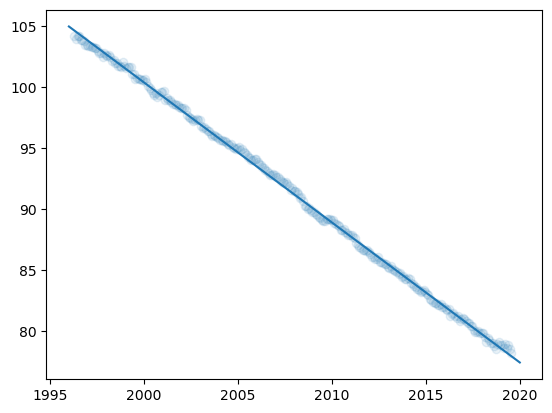

In [117]:
def line(x, m, b):
    return m*x + b

initial_guesses_1 = np.array([-1, 2100])
params_1, covariance_1 = scipy.optimize.curve_fit(line, data['decimal year'], data['CCl4ottoGLm'], initial_guesses_1)
x_1 = np.arange(1996, 2020, 0.01)
y_1 = line(x_1, -1.14604322, 2.39245212*1000)
plt.plot(x_1, y_1)
plt.scatter(data['decimal year'], data['CCl4ottoGLm'],alpha=0.1)

In [121]:
residuals = data['CCl4ottoGLm'] - line(data['decimal year'], -1.14604322, 2.39245212*1000)
chi_squared = np.sum((residuals / data['CCl4ottoGLsd'])**2)
dof = len(data['decimal year']) - 2  #degrees of freedom
reduced_chi_squared = chi_squared / dof
reduced_chi_squared

np.float64(4.606791114546583)

In [124]:
print(f"M: {params_1[0]} +/- {np.sqrt(covariance_1[0,0])}")
print(f"B: {params_1[1]} +/- {np.sqrt(covariance_1[1,1])}")
print(f"reduced chi squared: {reduced_chi_squared}")
print(f"Final equation: y = {params_1[0]} * x + {params_1[1]}")

M: -1.1460432206657578 +/- 0.002204244592647567
B: 2392.452122783485 +/- 4.425964386272087
reduced chi squared: 4.606791114546583
Final equation: y = -1.1460432206657578 * x + 2392.452122783485


Since the Reduced Chi Squared value isn't super close to one, it may not be good to have a linear fit. However, visually inspecting the line of best fit compared to the values shows that it might be a viable option if we ignore the chi square value.